In [1]:
!pip install scikit-posthocs
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.1 MB/s eta 0:00:00


In [2]:
import zipfile

# Define the path to the zip file
zip_path = "/content/Data for modelling.zip"
extract_path = "/content/Data_for_modelling"  # Folder to extract files

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [68]:
import pandas as pd
import numpy as np
ticker = 'NIKKEI'
df = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}.csv', index_col=0)
data = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}_return.csv')

data.index = df['Date']
data = data.dropna()

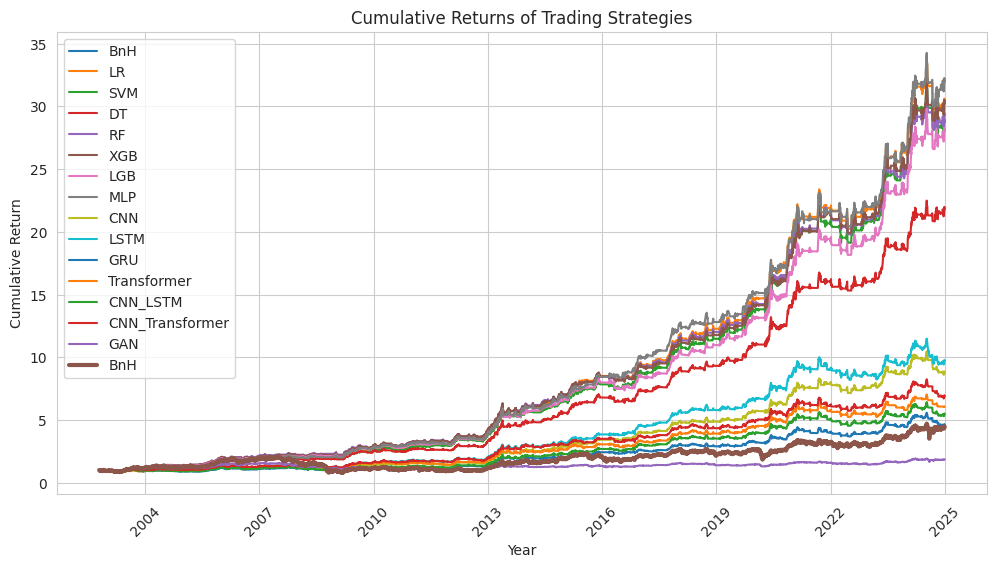

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure index is datetime
data.index = pd.to_datetime(data.index)

# Compute cumulative returns
cumulative_returns = (1 + data).cumprod()

# Plot
plt.figure(figsize=(12, 6))

for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.plot(cumulative_returns.index, cumulative_returns['BnH'], label='BnH', linewidth=3)

plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

# Format x-axis to show only years
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))  # Show every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.xticks(rotation=45)  # Rotate labels if needed

plt.legend()
plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.grid()
plt.savefig(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}_1.png')

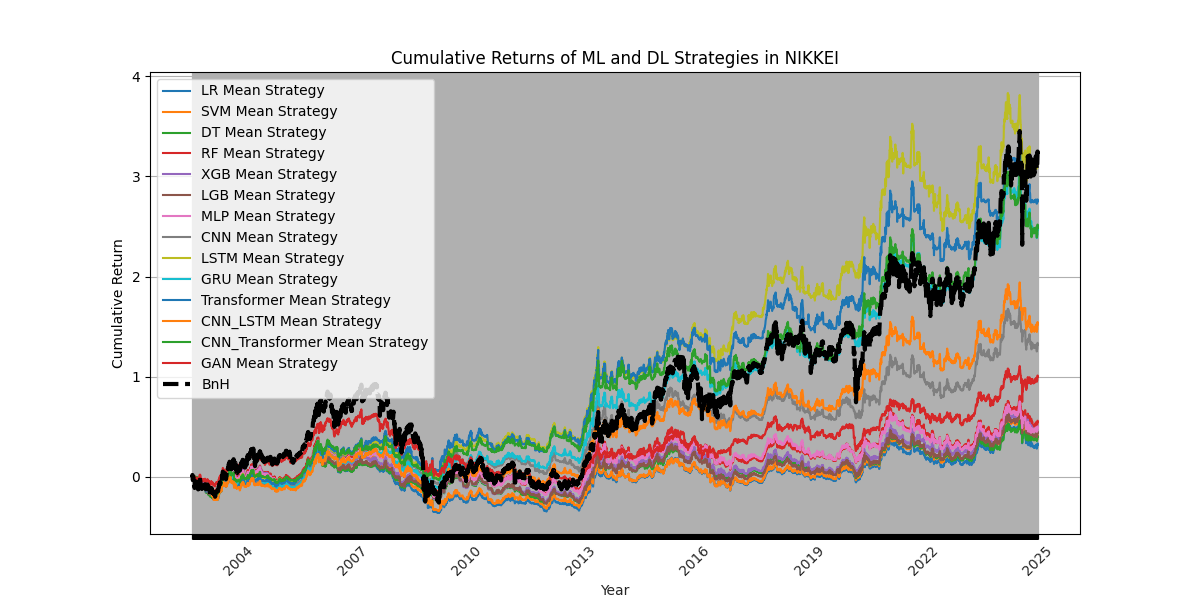

In [70]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import for Colab

# Load the two images
first_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}.png')   # Update path
second_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}_1.png') # Update path

# Convert images to grayscale to detect the date axis
gray_second = cv2.cvtColor(second_image, cv2.COLOR_BGR2GRAY)

# Crop the date axis from the second image (adjust if needed)
y_start = int(second_image.shape[0] * 0.9)  # Lower 10% contains the date axis
date_axis = second_image[y_start:, :]

# Remove the incorrect date axis from the first image (set that region to white)
first_image[y_start:, :] = 255  # White background

# Overlay the new date axis onto the first image
first_image[y_start:, :] = date_axis

# Save and display the fixed image
cv2.imwrite(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_final.png', first_image)
cv2_imshow(first_image)  # Use this instead of cv2.imshow()


# **Compare return**

In [71]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Reshape data: Convert from wide format to long format
data_long = data.reset_index().melt(id_vars="Date", var_name="model", value_name="daily_return")

# Get unique models (including 'BnH')
models = data.columns.tolist()

# Convert data to the format required for Kruskal-Wallis test
returns_data = [data[model].dropna().values for model in models]  # Drop NaNs

# Perform Kruskal-Wallis test
print("\n📊 Performing Kruskal-Wallis test on daily returns...\n")
test_stat, p_value = stats.kruskal(*returns_data)

# Display Kruskal-Wallis test result
if p_value < 0.05:
    print(f"⚠️ Kruskal-Wallis Test Result: p={p_value:.4f} → Significant Difference Found!")

    # Perform Nemenyi post-hoc test
    nemenyi_test = sp.posthoc_nemenyi(data_long, val_col="daily_return", group_col="model")

    # Format Nemenyi results to 4 decimal places
    nemenyi_test = nemenyi_test.map(lambda x: f"{x:.4f}")

    # Display Nemenyi test results
    print("\n📊 Nemenyi Test Results for Daily Returns:\n")
    print(nemenyi_test.to_string(index=True))
else:
    print(f"✅ No significant difference found (p={p_value:.4f})")




📊 Performing Kruskal-Wallis test on daily returns...

✅ No significant difference found (p=0.1919)


In [72]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Calculate daily return statistics for each model
summary_stats = pd.DataFrame(index=data.columns)

summary_stats['Mean_Return'] = data.mean()  # Mean daily return
summary_stats['Std_Dev'] = data.std()  # Standard deviation (volatility)
summary_stats['Skewness'] = data.apply(skew)  # Skewness (asymmetry)
summary_stats['Kurtosis'] = data.apply(kurtosis)  # Kurtosis (tail risk)

# Display results rounded to 4 decimal places
print(summary_stats.round(4))

                 Mean_Return  Std_Dev  Skewness  Kurtosis
BnH                   0.0004   0.0143   -0.3014    8.1353
LR                    0.0007   0.0076    0.0139    6.7083
SVM                   0.0006   0.0077   -0.0291    7.0777
DT                    0.0006   0.0073    0.0508    7.0497
RF                    0.0007   0.0077    0.0094    6.5212
XGB                   0.0007   0.0077   -0.0249    6.7922
LGB                   0.0006   0.0076   -0.0199    6.7156
MLP                   0.0007   0.0075   -0.0229    6.8292
CNN                   0.0004   0.0078   -0.1633    6.5871
LSTM                  0.0005   0.0080   -0.0490    6.6050
GRU                   0.0003   0.0079   -0.2544    6.4228
Transformer           0.0004   0.0080   -0.1808    6.4078
CNN_LSTM              0.0003   0.0080   -0.1681    5.9441
CNN_Transformer       0.0004   0.0079   -0.1895    6.4209
GAN                   0.0001   0.0072   -0.4562    6.3027


In [73]:
metrics = ['Total Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown [%]']
performance = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}_trading.csv', index_col=0)
print(performance.loc[metrics])

                                   LR                  SVM  \
Total Return [%]   32.225257311582304    40.47051031589725   
Sharpe Ratio      0.07862645029713167  0.11737243290047421   
Sortino Ratio     0.10971906675158569  0.16270739459037395   
Max Drawdown [%]    52.05237522207655   52.679100644789614   

                                   DT                   RF  \
Total Return [%]   39.859016251509274    54.66475644014293   
Sharpe Ratio      0.11052645725464989  0.17153414093319372   
Sortino Ratio     0.15387888944105832  0.23809452478737048   
Max Drawdown [%]    46.25106477063561    41.29216447128325   

                                  XGB                  LGB  \
Total Return [%]     48.9385692027622    43.92048103920611   
Sharpe Ratio       0.1506230548567788  0.13179510484735468   
Sortino Ratio     0.20928514751199254  0.18293243084101635   
Max Drawdown [%]    45.89941091027614    44.90584710006062   

                                  MLP                  CNN  \
Total

In [74]:
import vectorbt as vbt
bnh = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/{ticker}.csv', index_col=0)
bnh.index = bnh['Date']
bnh['signal'] = [1]*len(bnh)

In [75]:
data['close'] = bnh['close']
data['signal'] = bnh['signal']

In [76]:
p1 = vbt.Portfolio.from_signals(
        close=bnh['close'],
        entries=bnh.signal==1,  # Entries where signal is 1
        exits=bnh.signal == 0,  # Exits where signal is 0
        size=1,  # Assuming equal position size
        fixed_fees=0.001,  # Example transaction cost
        slippage=0.001,
        freq='1d'
    )
p1.stats(agg_func=None).T.loc[metrics]

,0
Total Return [%],320.756284
Sharpe Ratio,0.489181
Sortino Ratio,0.683201
Max Drawdown [%],61.367936


# **Accuracy**

In [77]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np
import os

# Define parameters
models = ['LR', 'SVM', 'DT', 'RF', 'XGB', 'LGB', 'MLP',
          'CNN', 'LSTM', 'GRU', 'Transformer',
          'CNN_LSTM', 'CNN_Transformer', 'GAN']

base_path = "/content/Data_for_modelling/Data for modelling/Developed/NIKKEI/"


# Load all model data into a single DataFrame
data_list = []
for model in models:
    file_path = os.path.join(base_path, f"{ticker}_{model}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['model'] = model  # Add model name column
        data_list.append(df)
        print(f"✅ Loaded {model} data successfully.")
    else:
        print(f"⚠️ {model} file not found at {file_path}. Skipping.")

# Merge all data
data = pd.concat(data_list, ignore_index=True)

# Get metric columns (excluding 'ticker' and 'model')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'MCC', 'AUC']

# Store results
kruskal_results = {}
nemenyi_results = {}

# Loop through each metric
for metric in metrics:
    print(f"\n📊 Performing Kruskal-Wallis test for {metric}...\n")

    # Extract values for all models
    metric_values = [data[data['model'] == model][metric] for model in models if model in data['model'].unique()]

    # Perform Kruskal-Wallis test
    test_stat, p_value = stats.kruskal(*metric_values)

    # Store Kruskal-Wallis results
    kruskal_results[metric] = {'p_value': p_value}

    # Print Kruskal-Wallis results
    if p_value < 0.05:
        print(f"⚠️ Kruskal-Wallis Result: p={p_value:.4f} → Significant Difference!")

        # Perform Nemenyi post-hoc test (Corrected version)
        nemenyi_test = sp.posthoc_nemenyi(data, val_col=metric, group_col='model')

        # Store Nemenyi results
        nemenyi_results[metric] = nemenyi_test

        print(f"\n📊 Nemenyi Test Results for {metric}:\n")
        print(nemenyi_test.round(4))
    else:
        print(f"✅ No significant difference found (p={p_value:.4f})")

# Print summary of Kruskal-Wallis tests
print("\n🔹 Summary of Kruskal-Wallis Test Results:")
kruskal_summary_df = pd.DataFrame(kruskal_results).T
print(kruskal_summary_df.round(4))

# Print summary of Nemenyi test results (if any)
if nemenyi_results:
    print("\n🔹 Summary of Nemenyi Test Results:")
    for metric, result in nemenyi_results.items():
        print(f"\n📊 Nemenyi test for {metric}:\n")
        print(result.round(4))

✅ Loaded LR data successfully.
✅ Loaded SVM data successfully.
✅ Loaded DT data successfully.
✅ Loaded RF data successfully.
✅ Loaded XGB data successfully.
✅ Loaded LGB data successfully.
✅ Loaded MLP data successfully.
✅ Loaded CNN data successfully.
✅ Loaded LSTM data successfully.
✅ Loaded GRU data successfully.
✅ Loaded Transformer data successfully.
✅ Loaded CNN_LSTM data successfully.
✅ Loaded CNN_Transformer data successfully.
✅ Loaded GAN data successfully.

📊 Performing Kruskal-Wallis test for Accuracy...

⚠️ Kruskal-Wallis Result: p=0.0000 → Significant Difference!

📊 Nemenyi Test Results for Accuracy:

                    CNN  CNN_LSTM  CNN_Transformer      DT     GAN     GRU  \
CNN              1.0000    0.9962           0.9176  0.0000  0.0000  0.6847   
CNN_LSTM         0.9962    1.0000           1.0000  0.0329  0.0000  0.9999   
CNN_Transformer  0.9176    1.0000           1.0000  0.1956  0.0006  1.0000   
DT               0.0000    0.0329           0.1956  1.0000  0.9957

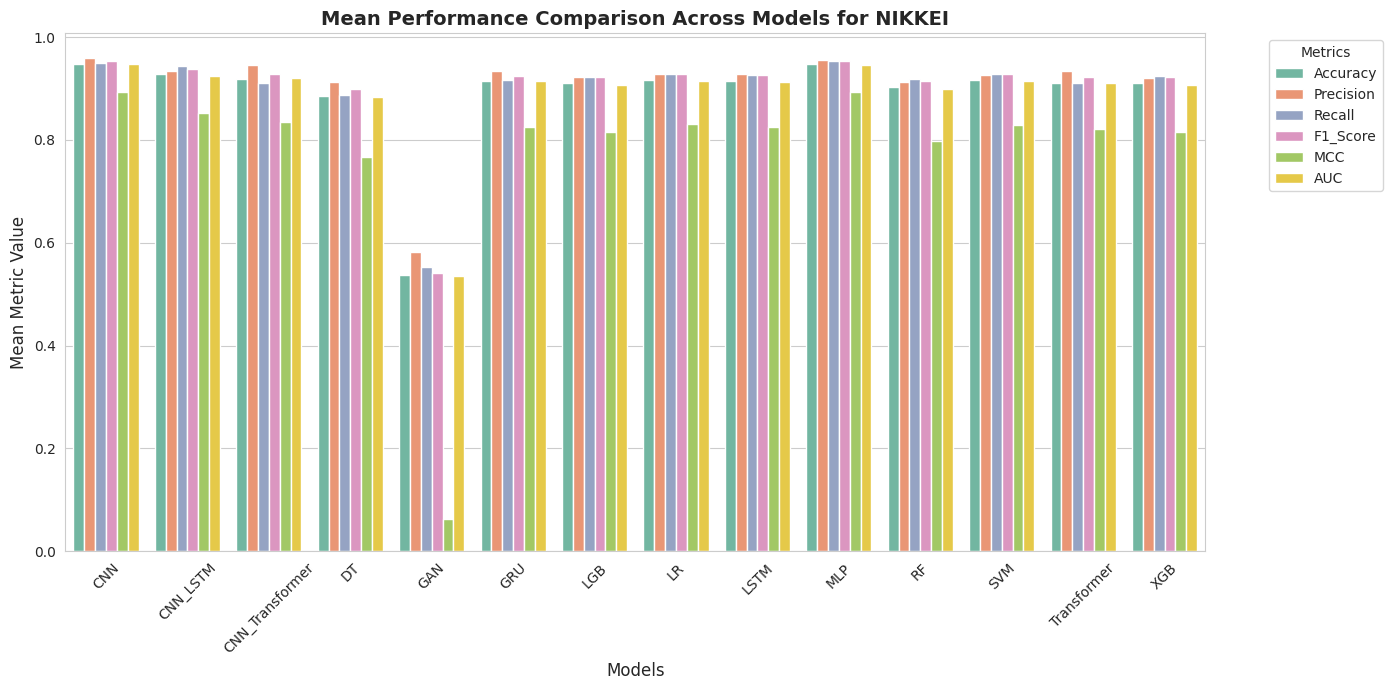

In [78]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
mean_performance = data.groupby('model')[metrics].mean().reset_index()

plt.figure(figsize=(14, 7))

# Reshape the data for Seaborn
data_melted = mean_performance.melt(id_vars=['model'], value_vars=metrics, var_name='Metric', value_name='Mean Value')

# Create a grouped bar plot
sns.set_style("whitegrid")
ax = sns.barplot(x='model', y='Mean Value', hue='Metric', data=data_melted, palette="Set2")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.title(f"Mean Performance Comparison Across Models for {ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Metric Value", fontsize=12)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [79]:
mean_performance.round(4)

,model,Accuracy,Precision,Recall,F1_Score,MCC,AUC
0,CNN,0.9477,0.9595,0.9496,0.9542,0.8937,0.9476
1,CNN_LSTM,0.9277,0.9333,0.9434,0.9377,0.8523,0.9245
2,CNN_Transformer,0.9186,0.9458,0.9118,0.9280,0.8356,0.9199
3,DT,0.8847,0.9124,0.8866,0.8983,0.7664,0.8834
4,GAN,0.5371,0.5821,0.5530,0.5417,0.0628,0.5353
5,GRU,0.9143,0.9346,0.9167,0.9252,0.8255,0.9142
6,LGB,0.9105,0.9218,0.9233,0.9225,0.8161,0.9076
7,LR,0.9173,0.9287,0.9283,0.9284,0.8301,0.9148
8,LSTM,0.9151,0.9283,0.9260,0.9268,0.8260,0.9127
9,MLP,0.9476,0.9555,0.9539,0.9543,0.8936,0.9466
